# CS412 Fall 2023-2024 Term Project (Individual)

## Contents
  1. Description
  2. Approach
  3. Preprocessing
  4. Prompt Matching
  5. Feature Extraction
  6. Training the Model
  7. Evaluating the Model





## 1. Description
Hello ML enthusiasts,

Let's chanllenge ourselves and work on a real-life problem. Our task is predicting the score of an assignment using how a student interacted with the ChatGPT system.

In the first assignment, you kindly provided your ChatGPT chat history and seperately your assignment were graded by our TAs. We are interested in predicting scores by extracting information from ChatGPT.

Since this is a real-world challenge and we don't know whether a significant level of accouracy is even possible, we will evaluate your projects considering the creativity and the different approaches you use for this assignment.



In the dataset you will find two files:

- dataset.zip : Compressed file for different ChatGPT chats as HTML files. Unique code in each file name represents the ID of the instance.

- scores.csv : This file has multiple rows corresponds to different file. First column is the ID that you can use to match HTML files and second column is the HW scores that you are going to predict.

- Assignment.ipynb : IPython notebook for the assignment.



Couple of hints:

- Dataset may have malformed files. You still need to predict scores for them (think about data imputation and prior distributions)

- Students may only ask some questions to ChatGPT. Predicting score require matching prompts with questions. (vector space models, text clustering etc.)

- Scores range between (0,100) that means you need be careful about the total score.



There will be plenty more assumptions or smart analysis you can conduct. Ali provided a video tutorial and starter code for this assignment. Please make sure to apply any necessary changes and improvements.

All Q&A about the project will be done on SUCourse. This exchange will help everyone to benefit from the information shared by everyone.

To deliver the project, we need one public Github repository for each team. Your repository must contain a README file with all the necessary descriptions and report the findings and approaches used to work on this task. Please also refer to the slides that we share about the project.

## 2. Approach

In this project, there are 3 main steps:
  1. Preprocessing the prompts obtained from the files and the questions in the homework.
  2. Matching the prompts with the relevant questions.
  3. By obtaining features from the question-prompt pairs and the scores from the homework, training a model to predict scores for the next homeworks.

I used **cosine similarity measure** between the questions and the prompts to see the correspondence levels of each prompt-question pairs. For each prompt, the most similar question is assigned to the prompt. Then, I extracted some features:

  1. **Number of prompts in a file**: This was already given in the examle colab file.
  2. **Question coverage**: After matching prompts with the questions in the homework, I acquired a set of numbers between 1-8 (numbers of the questions in the HW). The set consisted of the questions that are matched by the prompts for each file. Question coverage score is the ratio of the number of elements in this set and the total number of questions.
  3.**Point converage**: Since we already know the distribution of points, it might be useful to consider it and include it in our training set. It is similar to the feature above, however, point coverage is the ratio of the points of the questions that are covered by the prompts to 100.
  4. **Length of the prompts**: The training set in hand had variance in the length of the number and thus the length of the prompts.

PS: I worked individually in this project.


In [4]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# 3.  Preprocessing

In [5]:
data_path = "./*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:20<00:00,  6.25it/s]


In [6]:
print(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0]['text'])

Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. 



In [7]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [9]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [10]:
questions[0]

'Initialize\n*   First make a copy of the notebook given to you as a starter.\n*   Make sure you choose Connect form upper right.\n*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.\n\n'

In [11]:
#Remove HTML

import re
for i in range(len(questions)):
  questions[i] = questions[i].replace('\n*', ' ')
  questions[i] = questions[i].replace('*', '')
  questions[i] = questions[i].replace('(', '')
  questions[i] = questions[i].replace(')', '')
  questions[i] = questions[i].replace('>', '')
  questions[i] = questions[i].replace('\n', ' ')
  questions[i] = questions[i].replace('.', '')
  questions[i] = questions[i].replace(',', '')
  questions[i] = questions[i].replace('"', '')
  questions[i] = questions[i].replace('  ', ' ')
  questions[i] = questions[i].replace('-', '')
  questions[i] = questions[i].replace('?', '')
  questions[i] = questions[i].replace('&', '')
  questions[i] = questions[i].replace('%', '')
  questions[i] = questions[i].replace(':', '')
  questions[i] = questions[i].lower()
  questions[i] = questions[i].strip()
  questions[i] = re.sub('[0-9]+ pts', '', questions[i])
  questions[i] = re.sub('[0-9]+ points', '', questions[i])



In [12]:
questions[0:]

['initialize  first make a copy of the notebook given to you as a starter  make sure you choose connect form upper right  you may upload the data to the section on your left on colab than right click on the csv file and get the path of the file by clicking on copy path you will be using it when loading the data',
 'load training dataset     read the csv file with the pandas library',
 'understanding the dataset  preprocessing  understanding the dataset   find the shape of the dataset number of samples  number of attributes hint you can use the shape function  display variable names both dependent and independent  display the summary of the dataset hint you can use the info function  display the first 5 rows from training dataset hint you can use the head function preprocessing    check if there are any missing values in the dataset if there are you can either drop these values or fill it with most common values in corresponding rows be careful that you have enough data for training the

In [13]:
code2features = defaultdict(lambda : defaultdict(int))


for code, convs in code2convos.items():
    if len(convs) == 0:
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1


In [15]:
data = [{'code': code, 'user_prompts': values['#user_prompts']} for code, values in code2features.items()]

dataframe = pd.DataFrame(data)

print(dataframe)

                                     code  user_prompts
0    0031c86e-81f4-4eef-9e0e-28037abf9883            14
1    0225686d-b825-4cac-8691-3a3a5343df2b            18
2    041f950b-c013-409a-a642-cffff60b9d4b             9
3    04f91058-d0f8-4324-83b2-19c671f433dc            20
4    089eb66d-4c3a-4f58-b98f-a3774a2efb34            86
..                                    ...           ...
118  f24219d6-07f0-4baf-80ac-18475dc5b66f            21
119  f2f18684-4a16-4c05-a2d1-c0f96d1de869            71
120  f852596d-fdca-45aa-9050-d4f76ce6a53c            30
121  f8ec3336-fd48-4654-ad98-62ccfb96d096            14
122  fb8de815-224c-4d06-9fd4-7156d1a9920d            31

[123 rows x 2 columns]


# 4. Prompt Matching

In [16]:
!pip install nltk scikit-learn

In [17]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocess_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)

def calculate_cosine_similarity(text1, text2):
    preprocessed_text1 = preprocess_text(text1)
    preprocessed_text2 = preprocess_text(text2)

    vectorizer = CountVectorizer()
    vectors = vectorizer.fit_transform([preprocessed_text1, preprocessed_text2])

    cosine_sim = cosine_similarity(vectors)

    return cosine_sim[0, 1]



result_list = []


promp = defaultdict(lambda : defaultdict(int))

for code, prompts in code2prompts.items():
  if len(prompts) == 0:
      continue
  #print(f"\n------------------------\nThis is {code}")

  for i in range(len(prompts)):
    text1 = prompts[i]
    relevant_question = 1
    max_similarity = 0
    for j in range(1, 9):
      text2 = questions[j]
      similarity_score = calculate_cosine_similarity(text1, text2)
      if(similarity_score > max_similarity):
        max_similarity = similarity_score
        relevant_question = j
    result_list.append({
            'code': code,
            'prompt_index': i,
            'prompt' : text1,
            'most_similar_question': relevant_question,
            'similarity_score': max_similarity
        })
    #print(f"Cosine Similarity of prompt {i} and question {relevant_question}: {max_similarity}")




for result in result_list:
    print(result)



In [ ]:
allResponses = []
allPrompts = []
for code, convo in code2convos.items():
  for conv in convos:
    if conv["role"] == "assistant":
      allResponses.append(text)
    else:
      allPrompts.append(text)

print(len(allResponses))
print(len(allPrompts))

In [37]:
len(allPrompts)


3937

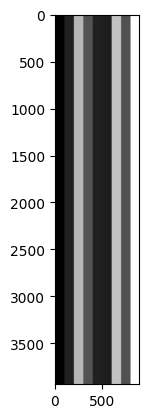

In [47]:
matrix = np.zeros((3937, 900))
for i in range(len(allPrompts)):
  text1 = allPrompts[i]
  relevant_question = 1
  max_similarity = 0
  for j in range(1, 9):
    text2 = questions[j]
    matrix[i, 100*j:(100*j)+100] = calculate_cosine_similarity(text1, text2)
plt.imshow(matrix, cmap='gray')
plt.show()

# 5. Feature Extraction

In [ ]:
def question_coverage(results):
    total_questions = 8
    code_coverage = {}

    for code, prompts_list in code2prompts.items():
      covered_questions = set()
      for result in results:
          if result['code'] == code:
            covered_questions.add(result['most_similar_question'])
      coverage_ratio = len(covered_questions) / total_questions
      code_coverage[code] = coverage_ratio

    return code_coverage

code2coverage = question_coverage(result_list)

for code, coverage in code2coverage.items():
    print(f"Code: {code}, Coverage: {coverage}")


In [ ]:
def code2point_coverage(results):
    total_points = 100
    question_points = {
        1: 0,
        2: 5,
        3: 20,
        4: 10,
        5: 20,
        6: 15,
        7: 20,
        8: 10
    }

    code_coverage = {}

    for code, prompts_list in code2prompts.items():
      covered_points = 0
      covered_questions = set()
      for result in results:
          if result['code'] == code:
            covered_questions.add(result['most_similar_question'])


      for question in covered_questions:
        covered_points += question_points[question]
      coverage_ratio = covered_points / total_points
      code_coverage[code] = coverage_ratio

    return code_coverage


code2point_coverage_result = code2point_coverage(result_list)

for code, coverage in code2point_coverage_result.items():
    print(f"Code: {code}, Point Coverage: {coverage}")

In [ ]:
def code2length(prompts):
    code_lengths = {}

    for code, prompts_list in prompts.items():
        total_length = 0

        for prompt in prompts_list:
            total_length += len(prompt.split())

        code_lengths[code] = total_length

    return code_lengths

code2length_result = code2length(code2prompts)


max_length = 0
for code, length in code2length_result.items():
  if length > max_length:
    max_length = length
for code, length in code2length_result.items():
  length = length/max_length
  print(f"Code: {code}, Ratio of Length of Prompts: {length}")

In [ ]:
def certainly(results):
    total_questions = 8
    certainly_num = {}

    for code, convos in code2convos.items():
      total = 0
      for conv in convos:
        if(conv['role'] == "assistant"):
          total += conv['text'].count("Certainly")
      certainly_num[code] = total
    return certainly_num

code2certainly= certainly(result_list)

for code, count in code2certainly.items():
  code2certainly[code] = count
  print(f"Code: {code}, Coverage: {count}")


In [52]:
df_length = pd.DataFrame(list(code2length_result.items()), columns=['code', 'length'])
df_point_coverage = pd.DataFrame(list(code2point_coverage_result.items()), columns=['code', 'point_coverage'])
df_coverage = pd.DataFrame(list(code2coverage.items()), columns=['code', 'coverage'])

# Merge DataFrames on the 'code' column
final_df = pd.merge(df_length, df_point_coverage, on='code')
final_df = pd.merge(final_df, df_coverage, on='code')

# Print or use the final DataFrame as needed
print(final_df)

                                     code  length  point_coverage  coverage
0    0031c86e-81f4-4eef-9e0e-28037abf9883     883            0.65     0.750
1    0225686d-b825-4cac-8691-3a3a5343df2b     709            1.00     1.000
2    041f950b-c013-409a-a642-cffff60b9d4b     878            0.50     0.625
3    04f91058-d0f8-4324-83b2-19c671f433dc     355            0.85     0.875
4    089eb66d-4c3a-4f58-b98f-a3774a2efb34    2474            1.00     1.000
..                                    ...     ...             ...       ...
122  f24219d6-07f0-4baf-80ac-18475dc5b66f     648            1.00     1.000
123  f2f18684-4a16-4c05-a2d1-c0f96d1de869    2965            1.00     1.000
124  f852596d-fdca-45aa-9050-d4f76ce6a53c    2533            1.00     1.000
125  f8ec3336-fd48-4654-ad98-62ccfb96d096     978            1.00     1.000
126  fb8de815-224c-4d06-9fd4-7156d1a9920d    1445            1.00     1.000

[127 rows x 4 columns]


In [53]:
max_length = 0
for index, row in final_df.iterrows():
  if(row['length'] > max_length):
    max_length = row['length']

max_length

7204

In [54]:
new_length = final_df['length']/7204
final_df['length'] = new_length

In [55]:
final_df

,code,length,point_coverage,coverage
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.122571,0.65,0.750
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.098418,1.00,1.000
2,041f950b-c013-409a-a642-cffff60b9d4b,0.121877,0.50,0.625
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.049278,0.85,0.875
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.343420,1.00,1.000
...,...,...,...,...
122,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.089950,1.00,1.000
123,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.411577,1.00,1.000
124,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.351610,1.00,1.000
125,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.135758,1.00,1.000


In [57]:
scores = pd.read_csv("/content/scores.csv")

scores.head()

,Unnamed: 0,code,grade
0,0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


In [58]:
df = pd.merge(final_df, scores, on='code')

df

,code,length,point_coverage,coverage,Unnamed: 0,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.122571,0.65,0.750,134,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.098418,1.00,1.000,85,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,0.121877,0.50,0.625,104,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.049278,0.85,0.875,1,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.343420,1.00,1.000,81,100.0
...,...,...,...,...,...,...
139,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.411577,1.00,1.000,59,100.0
140,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.351610,1.00,1.000,94,98.0
141,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.135758,1.00,1.000,84,100.0
142,fb8de815-224c-4d06-9fd4-7156d1a9920d,0.200583,1.00,1.000,37,98.0


In [59]:
df = pd.merge(df, dataframe, on='code')

df



,code,length,point_coverage,coverage,Unnamed: 0,grade,user_prompts
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.122571,0.65,0.750,134,48.0,14
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.098418,1.00,1.000,85,99.0,18
2,041f950b-c013-409a-a642-cffff60b9d4b,0.121877,0.50,0.625,104,90.0,9
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.049278,0.85,0.875,1,97.0,20
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.343420,1.00,1.000,81,100.0,86
...,...,...,...,...,...,...,...
135,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.411577,1.00,1.000,59,100.0,71
136,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.351610,1.00,1.000,94,98.0,30
137,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.135758,1.00,1.000,84,100.0,14
138,fb8de815-224c-4d06-9fd4-7156d1a9920d,0.200583,1.00,1.000,37,98.0,31


In [60]:
df['user_prompts'] = df['user_prompts']/max(df['user_prompts'])

df = df.drop(df.columns[4], axis = 1)

df

,code,length,point_coverage,coverage,grade,user_prompts
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.122571,0.65,0.750,48.0,0.14
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.098418,1.00,1.000,99.0,0.18
2,041f950b-c013-409a-a642-cffff60b9d4b,0.121877,0.50,0.625,90.0,0.09
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.049278,0.85,0.875,97.0,0.20
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.343420,1.00,1.000,100.0,0.86
...,...,...,...,...,...,...
135,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.411577,1.00,1.000,100.0,0.71
136,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.351610,1.00,1.000,98.0,0.30
137,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.135758,1.00,1.000,100.0,0.14
138,fb8de815-224c-4d06-9fd4-7156d1a9920d,0.200583,1.00,1.000,98.0,0.31


# 6. Training the Model

In [62]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler


# Assuming df is your DataFrame with columns including features and target variable
# Replace 'target_column' with the actual name of your target variable column
target_column = 'grade'

# Split the data into features (X) and target variable (y)
X = df.drop(columns=[target_column, 'code'])
y = df[target_column]

X.dropna()
y.dropna()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train.fillna(0, inplace=True)

In [67]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=3)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=0)

# Evaluating the Model

In [68]:
from sklearn.metrics import accuracy_score


y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 86.01153946995464
MSE TEST: 260.1365865217152
R2 Train: 0.5417012497170547
R2 TEST: -0.05517341842285495
